<div style="text-align: center;"> 
    <span style="font-size: 40px; font-weight: bold">
        CSC17104 – PROGRAMING FOR DATA SCIENCE
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 32px; font-weight: bold">
        FINAL PROJECT
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 24px; font-weight: bold">
        <i>
            Question Answering (1, 2)
        </i>
    </span>
</div>

<div style="text-align: right;">
    <span style="font-size: 14px">
        <i>
            Dec 9, 2025
        </i>
    </span>
</div>

| Name | ID |
| --- | --- |
| Lê Võ Nhật Minh | 22120210 |

---

<h1 align="center">
    <span style="font-size: 40px; font-weight: bold">
        Mục lục
    </span style>
</h1>

I. [**Question 1:**](#i)

II. [**Question 2:**](#ii)

---

In [1]:
# ======================
# Core libraries
# ======================
import numpy as np
import pandas as pd

# ======================
# Visualization
# ======================
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Statistics
# ======================
from scipy import stats

# ======================
# Scikit-learn utilities
# ======================
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder
)
from sklearn.metrics import (
    accuracy_score,
    classification_report
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.isotonic import IsotonicRegression

# ======================
# XGBoost
# ======================
import xgboost as xgb
from xgboost import XGBRegressor

# ======================
# Model explainability
# ======================
import shap


In [2]:
FILE_PATH = r'/kaggle/input/cleaned-data/ObesityDataSet_Cleaned.csv'

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print("Error: No file found!")
    exit()

<h1 id="i" style="font-weight: bold">I. Question 1: Does the habit of Calorie Consumption Monitoring (SCC) significantly mitigate or reverse the risk of severe obesity among individuals who otherwise maintain unhealthy dietary patterns, specifically High Caloric Food Intake (FAVC) or Alcohol Consumption (CALC)?</h1>

---

<h1 id="ii" style="font-weight: bold">II. Question 2: Can we develop a multi-class classification Machine Learning model (e.g., Random Forest or XGBoost) to accurately predict individual Obesity Levels (NObeyesdad) and subsequently utilize SHAP (SHapley Additive exPlanations) values to prescribe a personalized, optimal roadmap of modifiable lifestyle changes (specifically FCVC, CH2O, TUE, FAF) that maximizes the probability of transitioning a subject from an 'Obese' category to a 'Normal' or 'Overweight' category?</h1>


<h2 id="ii_1" style="font-weight: bold">1. Multi-class classification approach</h2>

The dataset is preprocessed by separating features from the target variable `NObeyesdad`, while excluding the `Weight` attribute to avoid data leakage. Ordinal lifestyle variables (e.g., food and alcohol consumption frequency) are encoded using severity-preserving mappings, and binary behavioral features are converted to 0/1 values.

The target variable is encoded as an ordinal severity scale, reflecting increasing levels of obesity. Features are categorized into numerical and nominal categorical variables for appropriate downstream processing. Additionally, a subset of actionable lifestyle features is identified for later use in behavior-based recommendation and prescription tasks.

In [3]:
# ==========================================
# 1. LOAD DATA & PREPROCESSING
# ==========================================

# Separate Features and Target
# We exclude 'Weight' to avoid data leakage, since the objective is to predict health status
# based on lifestyle habits rather than body measurements.
X = df.drop(columns=['NObeyesdad', 'Weight'])
y = df['NObeyesdad']


# ------------------------------------------
# Ordinal Encoding for Frequency-based Features
# CAEC: Consumption of food between meals
# CALC: Alcohol consumption
# ------------------------------------------
ordinal_mappings = {
    'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
    'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
}


# ------------------------------------------
# Binary Encoding for Yes/No Features
# ------------------------------------------
binary_mappings = {
    'FAVC': {'no': 0, 'yes': 1},   # High-calorie food consumption
    'SMOKE': {'no': 0, 'yes': 1},  # Smoking habit
    'SCC': {'no': 0, 'yes': 1},    # Calorie consumption monitoring
    'family_history_with_overweight': {'no': 0, 'yes': 1}
}

# Apply ordinal and binary mappings
for col, mapping in {**ordinal_mappings, **binary_mappings}.items():
    X[col] = X[col].map(mapping)


# ------------------------------------------
# Target Encoding (Severity-based Ordering)
# We treat obesity levels as an ordinal severity scale
# ------------------------------------------
severity_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

target_names = list(severity_mapping.keys())
y_encoded = y.map(severity_mapping)


# ------------------------------------------
# Feature Type Definition
# ------------------------------------------

# Categorical features (non-ordinal, nominal)
categorical_features = ['Gender', 'MTRANS']

# Numerical features (already numeric after encoding)
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


# ------------------------------------------
# Actionable Features
# These variables represent behaviors that can be modified
# FCVC: Vegetable consumption
# CH2O: Water intake
# FAF: Physical activity frequency
# TUE: Time using electronic devices
# ------------------------------------------
actionable_features = ['FCVC', 'CH2O', 'FAF', 'TUE']

In [4]:
# ------------------------------------------
# Data Preprocessing Pipeline
# ------------------------------------------
# - Numerical features are standardized using StandardScaler
# - Categorical features are encoded using One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
)


# ------------------------------------------
# Train / Test Split
# We use stratified sampling to preserve the class distribution
# of obesity severity levels in both sets
# ------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


# ------------------------------------------
# Fit Preprocessing Pipeline on Training Data
# ------------------------------------------
X_train_processed = preprocessor.fit_transform(X_train)

# Apply the same transformations to the test set
X_test_processed = preprocessor.transform(X_test)


# ------------------------------------------
# Retrieve Feature Names after One-Hot Encoding
# Required for model interpretability (e.g., SHAP analysis)
# ------------------------------------------
feature_names = (
    numerical_features
    + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
)

# Convert processed test data back to DataFrame
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

I initialized the XGBoost Classifier with the parameter `objective='multi:softprob'`.


Here I use "Soft Probabilities" because unlike a standard classifier that outputs a single label, this objective forces the model to output a probability distribution across all 7 obesity classes (e.g., [0.1, 0.8, 0.1...]). These detailed probabilities are essential for calculating the continuous "Risk Score" in the subsequent prescription phase, allowing us to measure granular improvements even if the class label doesn't change immediately.

In [5]:
# ==========================================
# 2. MODEL TRAINING (XGBoost)
# ==========================================

# Initialize XGBoost classifier for multi-class obesity severity prediction
# We use 'multi:softprob' to obtain class probabilities
clfer = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# Train the model on the processed training data
print("\nTraining model...")
clfer.fit(X_train_processed, y_train)


# ------------------------------------------
# Preliminary Model Evaluation
# ------------------------------------------
# Predict severity classes on the test set
y_pred = clfer.predict(X_test_processed)

# Report overall accuracy and per-class performance
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))



Training model...

Accuracy: 0.8014354066985646
                     precision    recall  f1-score   support

Insufficient_Weight       0.82      0.87      0.84        53
      Normal_Weight       0.57      0.58      0.57        57
 Overweight_Level_I       0.67      0.76      0.71        55
Overweight_Level_II       0.80      0.71      0.75        58
     Obesity_Type_I       0.80      0.80      0.80        70
    Obesity_Type_II       0.95      0.90      0.92        60
   Obesity_Type_III       1.00      0.97      0.98        65

           accuracy                           0.80       418
          macro avg       0.80      0.80      0.80       418
       weighted avg       0.81      0.80      0.80       418



Looking at the classification report, the model achieves an overall accuracy of ~80.1% which can be observed from the report are:
1.  High Severity Detection: The model performs exceptionally well on `Obesity_Type_III` (F1-score $\approx$ 0.98). This indicates high reliability in identifying the most critical cases requiring medical attention.
2.  Borderline Ambiguity: Performance is lower for `Overweight_Level_I` (F1-score $\approx$ 0.71). This reflects the fuzzy, non-linear boundary between "Normal" and "Slightly Overweight" lifestyles, which is inherently difficult to distinguish based solely on habits.

For severe obesity, small lifestyle changes might not immediately shift the patient to a "Normal" class, causing the model to see "zero improvement."

To address with the problem, we calculate an Expected Risk Score (Weighted Sum of Probabilities $\times$ Severity), so that the system selects the action that maximizes the Reduction in Risk Score, ensuring that every positive effort is recognized and recommended, even for high-risk patients.

In [6]:
# ==========================================
# 1. RISK SCORE CONFIGURATION
# ==========================================
# Severity mapping for ordinal risk computation
# 0: Least severe  ->  6: Most severe
severity_weights = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

def calculate_risk_score(probs, target_names):
    """
    Compute the Expected Risk Score (ordinal severity expectation).
    Formula:
        Risk = sum_i P(class_i) * severity(class_i)
    """
    score = 0.0
    for i, prob in enumerate(probs):
        class_name = target_names[i]
        weight = severity_weights.get(class_name, 0)
        score += prob * weight
    return score

In [7]:
# ==========================================
# 2. HEALTHY CLASS INDEX UTILITY
# ==========================================

def get_target_class_indices(target_names):
    """
    Return indices corresponding to non-obese / healthier categories.
    """
    healthy_labels = [
        'Insufficient_Weight',
        'Normal_Weight',
        'Overweight_Level_I',
        'Overweight_Level_II'
    ]
    healthy_indices = [
        i for i, name in enumerate(target_names)
        if name in healthy_labels
    ]
    return healthy_indices


Here I implemented a two-step framework for personalized advice:
1.  Diagnosis (Why?): Using SHAP (SHapley Additive exPlanations) to interpret the model's output. It reveals which specific features (e.g., low physical activity) contributed most to the current obesity classification. To be more specific, here we'll get into detail about the advantage of SHAP over Traditional Feature Importance

    * Unlike global feature importance, SHAP provides instance-level explanations, allowing the model to identify why a specific patient is classified at a given obesity level. In this prescription engine, SHAP quantifies both the direction and magnitude of each feature’s contribution to the predicted risk, enabling medically meaningful interpretation.
    
    * This makes SHAP particularly suitable for personalized lifestyle recommendations, as it supports counterfactual reasoning by revealing which actionable behaviors most strongly drive an individual’s risk, rather than relying on population-level averages.
2.  Prescription (What to do?): Using Counterfactual Simulation. Iteratively modify actionable features (`FAF`, `FCVC`, `CH2O`, `TUE`) and re-evaluate the patient.

In [8]:
# ==========================================
# 3. PRESCRIPTION ENGINE (Risk-Aware)
# ==========================================
explainer = shap.TreeExplainer(clfer)

def generate_prescription(patient_idx,
                          X_original,
                          X_processed_df,
                          clfer,
                          explainer,
                          target_names,
                          preprocessor):
    """
    Generate a personalized lifestyle prescription using:
    - Model predictions
    - Expected ordinal risk score
    - SHAP-based explanation
    - Counterfactual simulation on actionable features
    """

    # --- STEP 1: LOAD PATIENT DATA & CURRENT PREDICTION ---
    patient_data_processed = X_processed_df.iloc[[patient_idx]]
    patient_data_original = X_original.iloc[[patient_idx]]

    current_probs = clfer.predict_proba(patient_data_processed)[0]
    current_class_idx = np.argmax(current_probs)
    current_class_name = target_names[current_class_idx]

    # Compute current expected risk score
    current_risk_score = calculate_risk_score(current_probs, target_names)

    # Compute probability of being in healthier categories
    healthy_indices = get_target_class_indices(target_names)
    current_healthy_prob = np.sum(current_probs[healthy_indices])

    print(f"\n{'='*50}")
    print(f"PRESCRIPTION FOR PATIENT #{patient_idx}")
    print(f"{'='*50}")
    print(f"Current Status:     {current_class_name}")
    print(f"Current Risk Score: {current_risk_score:.2f} (Scale 0-6)")
    print(f"Prob. of Healthy:   {current_healthy_prob:.2%}")

    # If already in a non-obese category, no prescription is required
    if current_class_name in ['Normal_Weight', 'Insufficient_Weight']:
        print(">> Subject is already in a non-obese category.")
        return

    # --- STEP 2: MODEL EXPLANATION (SHAP) ---
    print("\n[Diagnosis] Why this status?")
    shap_values = explainer.shap_values(patient_data_processed)

    # For multiclass models, select SHAP values of the predicted class
    if isinstance(shap_values, list):
        sv = shap_values[current_class_idx]
    else:
        sv = shap_values

    shap.summary_plot(sv, patient_data_processed, feature_names=feature_names, plot_type="bar", show=False)
    
    plt.gcf().set_size_inches(10, 6)
    plt.tight_layout()
    
    plt.show()

    # --- STEP 3: COUNTERFACTUAL SIMULATION ---
    print("\n[Prescription] Simulating lifestyle changes...")

    simulation_results = []

    # Domain constraints for actionable features (from dataset definition)
    bounds = {
        'FCVC': (1, 3),   # Vegetable consumption
        'CH2O': (1, 3),   # Water intake
        'FAF':  (0, 3),   # Physical activity frequency
        'TUE':  (0, 2)    # Technology use time
    }

    actionable_features = ['FCVC', 'CH2O', 'FAF', 'TUE']

    for feature in actionable_features:
        original_val = patient_data_original[feature].values[0]

        # Heuristic: increase beneficial behaviors, decrease harmful ones
        if feature in ['FAF', 'FCVC', 'CH2O']:
            candidates = [v for v in [1, 2, 3] if v > original_val]
        else:  # TUE
            candidates = [v for v in [0, 1] if v < original_val]

        for new_val in candidates:
            # 1. Create counterfactual raw sample
            temp_user_raw = patient_data_original.copy()
            temp_user_raw[feature] = new_val

            # 2. Apply the same preprocessing pipeline
            temp_user_processed = preprocessor.transform(temp_user_raw)

            # 3. Predict new probabilities
            new_probs = clfer.predict_proba(temp_user_processed)[0]

            # Compute new expected risk and improvements
            new_risk_score = calculate_risk_score(new_probs, target_names)
            risk_reduction = current_risk_score - new_risk_score

            new_healthy_prob = np.sum(new_probs[healthy_indices])
            prob_increase = new_healthy_prob - current_healthy_prob

            simulation_results.append({
                'Feature': feature,
                'Original': original_val,
                'New': new_val,
                'Risk_Reduction': risk_reduction,  # Primary objective
                'Prob_Increase': prob_increase,    # Secondary objective
                'New_Risk_Score': new_risk_score
            })

    # --- STEP 4: SELECT BEST ACTION ---
    results_df = pd.DataFrame(simulation_results)

    if results_df.empty:
        print(">> No actionable changes found (user may already be at bounds).")
        return

    # Prioritize ordinal risk reduction
    results_df = results_df.sort_values(by='Risk_Reduction', ascending=False)
    best = results_df.iloc[0]

    # Acceptance thresholds
    if best['Risk_Reduction'] > 0.05 or best['Prob_Increase'] > 0.01:
        print("\nRECOMMENDED ACTION:")
        print(f"Change **{best['Feature']}** from {best['Original']} to {best['New']}")
        print(f"-> Risk Score reduces by: {best['Risk_Reduction']:.2f}")
        print(f"-> Probability of Healthy increases by: {best['Prob_Increase']:.2%}")

        print("\nAlternative Options:")
        cols_to_show = ['Feature', 'Original', 'New', 'Risk_Reduction', 'Prob_Increase']
        print(results_df[cols_to_show].head(3).to_string(index=False))
    else:
        print(">> Single lifestyle changes show minimal impact. Consider multi-factor changes.")



PRESCRIPTION FOR PATIENT #0
Current Status:     Obesity_Type_III
Current Risk Score: 5.96 (Scale 0-6)
Prob. of Healthy:   0.63%

[Diagnosis] Why this status?


The figure layout has changed to tight


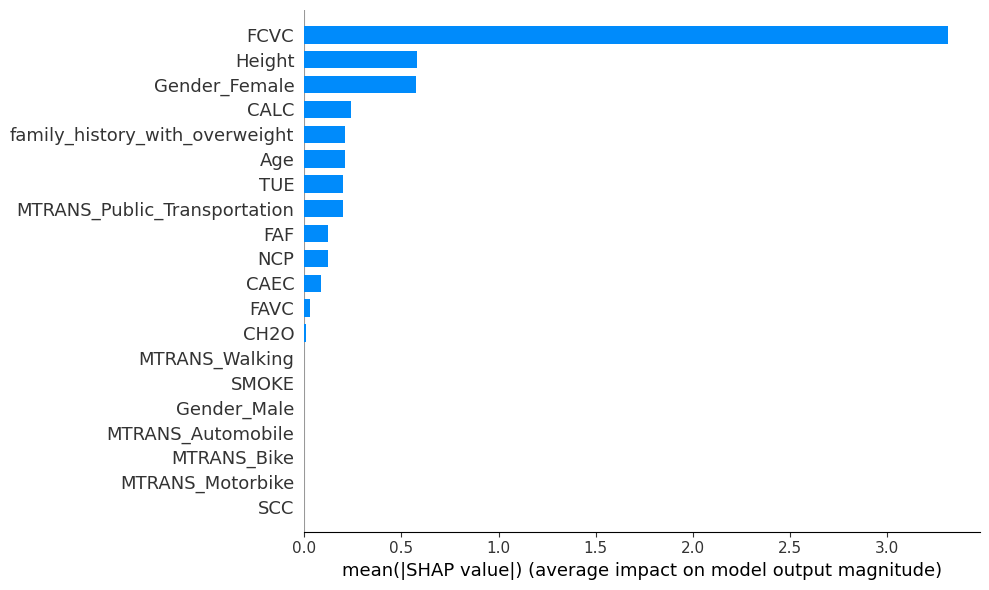


[Prescription] Simulating lifestyle changes...

RECOMMENDED ACTION:
Change **FAF** from 0 to 3
-> Risk Score reduces by: 0.40
-> Probability of Healthy increases by: 8.62%

Alternative Options:
Feature  Original  New  Risk_Reduction  Prob_Increase
    FAF         0    3        0.398800       0.086207
    FAF         0    2        0.376682       0.082324
   CH2O         2    3        0.004349       0.000267


In [9]:
# ==========================================
# 4. EXECUTION DEMO
# ==========================================

health_condition = 'Obesity_Type_III'

# Find patients diagnosed with Obesity Type III in the test set
obesity_indices = np.where(y_test == severity_mapping[health_condition])[0]

if len(obesity_indices) > 0:
    # Select the first patient with Obesity Type III
    sample_patient_idx = obesity_indices[0]
    
    # Since X_test was shuffled during train-test split,
    # we must use the row index corresponding to X_test
    # Note: generate_prescription expects the row index (0...n) of X_test
    generate_prescription(
        sample_patient_idx,
        X_test,
        X_test_df,
        clfer,
        explainer,
        target_names,
        preprocessor
    )
else:
    print(f"No samples with condition {health_condition} found in the test set.")

From the result above, here is a concise interpretation:
- Diagnosis (Current Status)
    * Severe Condition: The patient is currently classified as Obesity Type III (the most severe category).
    * Critical Risk: The Risk Score of 5.96 (on a scale of 0–6) confirms this severity, indicating the patient is at the extreme end of the obesity spectrum.
    * Low Health Probability: There is currently only a 0.63% probability that this patient falls into a "Healthy" or "Manageable" weight category, meaning their current lifestyle is heavily driving the obesity diagnosis.

- The Prescription (Recommended Action): the model has identified Physical Activity (`FAF`) as the most critical "lever" for this specific patient to improve their health.
    
    * Best Action: Increasing physical activity from Level 0 (None) to Level 3 (High).
    * Impact:
        * Risk Score Reduction (-0.40): This is a significant improvement. While it does not instantly "cure" the patient (the new score would be ~5.56, likely moving them towards Obesity Type II), it represents a substantial step away from the most dangerous risk level.
        * Health Probability Increase (+8.62): This is a massive relative improvement (increasing the chance of health by more than 10x compared to the baseline), showing that exercise is the primary driver for weight management in this case.

- Comparative Insight
    * Exercise vs. Water: The model shows that increasing water intake (`CH2O` from 2 to 3) only reduces risk by 0.004 which is negligible.
    * Conclusion: For Patient #0, "drinking more water" is not the solution. The data clearly shows that sedentary behavior (lack of exercise) is the root cause, and addressing it provides the highest return on effort.

Although the problem can be addressed using standard multi-class classification models, we observe that the target variable NObeyesdad exhibits a clear ordinal structure (Insufficient Weight < Normal Weight < … < Obesity Type III).

Conventional multi-class classifiers, typically optimized with softmax activation and cross-entropy loss, treat class labels as nominal and mutually independent. This leads to a theoretical limitation: the loss function penalizes misclassifying an instance from Obesity Type III as Normal Weight in the same manner as misclassifying it as Obesity Type II, despite the substantial difference in severity between these two errors.

To address this limitation and to explicitly exploit the ordered nature of obesity severity levels, we adopt an ordinal classification approach based on the Frank and Hall decomposition. This method decomposes the original multi-class problem into a sequence of binary classification tasks defined over increasing thresholds. As a result, the model learns that higher obesity levels can only be attained after exceeding all lower severity levels, thereby aligning the learning process with the inherent ordinal structure of the target variable.

<h2 id="ii_2" style="font-weight: bold">2. Ordinal classification approach</h2>

This function enforces the ordinal constraint that probabilities ( $P(y > k)$ ) must be monotonically decreasing across thresholds. It uses isotonic regression to correct inconsistencies in the outputs of binary classifiers, ensuring ordinal validity without relying on heuristic clipping.


In [10]:
def isotonic_fix(p):
    """
    Enforce monotonic decreasing constraint on probabilities P(y > k).

    This function applies Isotonic Regression to ensure:
        P(y > 0) >= P(y > 1) >= ... >= P(y > K-1)

    This guarantees ordinal consistency without ad-hoc clipping.

    Parameters
    ----------
    p : array-like of shape (K-1,)
        Raw predicted probabilities P(y > k) from binary classifiers.

    Returns
    -------
    array-like of shape (K-1,)
        Monotonically decreasing probabilities.
    """
    ir = IsotonicRegression(increasing=False, out_of_bounds='clip')
    x = np.arange(len(p))
    return ir.fit_transform(x, p)

This ordinal classifier implements the Frank & Hall decomposition by transforming a multi-class ordinal problem into a sequence of binary classification tasks. Instead of directly predicting class labels, the model learns cumulative probabilities of the form ( $P(y > k)$ ), which naturally encode the ordered structure of the target variable.

During inference, these cumulative probabilities are post-processed to enforce monotonicity, ensuring ordinal consistency. The final class probabilities are then reconstructed by taking differences between consecutive cumulative probabilities. This design allows the model to explicitly respect the ordinal nature of the labels while remaining compatible with any standard binary classifier as the base estimator.


In [11]:
# ==========================================
# 1. ORDINAL CLASSIFIER DEFINITION
# ==========================================
class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    """
    Ordinal Classification model based on Frank & Hall decomposition.

    This approach decomposes a K-class ordinal problem into K-1
    binary classification tasks of the form:

        P(y > k)  for k = 0, 1, ..., K-2

    Final class probabilities are reconstructed from these cumulative
    probabilities while preserving ordinal constraints.
    """

    def __init__(self, base_estimator=None):
        """
        Parameters
        ----------
        base_estimator : sklearn-compatible binary classifier
            Base model used to learn each binary sub-problem
            (e.g., LogisticRegression, XGBClassifier).
        """
        self.base_estimator = base_estimator
        self.classifiers_ = {}
        self.classes_ = None
        
    def fit(self, X, y):
        """
        Train K-1 binary classifiers for ordinal decomposition.

        Each classifier k learns:
            P(y > k)

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training features.
        y : array-like, shape (n_samples,)
            Ordinal class labels encoded as integers.

        Returns
        -------
        self
        """
        self.classes_ = np.sort(np.unique(y))
        n_classes = len(self.classes_)
        
        # Train K-1 binary classifiers
        for i in range(n_classes - 1):
            # Binary target:
            # 1 if true label > class_i, else 0
            y_binary = (y > self.classes_[i]).astype(int)
            
            clf = clone(self.base_estimator)
            clf.fit(X, y_binary)
            self.classifiers_[i] = clf
            
        return self

    
    def predict_proba(self, X):
        """
        Predict class probabilities using ordinal reconstruction.

        Steps:
        1. Predict cumulative probabilities P(y > k)
        2. Enforce monotonicity via isotonic regression
        3. Recover class probabilities:
           - P(y=0) = 1 - P(y>0)
           - P(y=k) = P(y>k-1) - P(y>k)
           - P(y=K-1) = P(y>K-2)

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)

        Returns
        -------
        final_probas : ndarray, shape (n_samples, n_classes)
            Valid probability distribution over ordinal classes.
        """

        # Step 1: Predict cumulative probabilities P(y > k)
        probas_gt = {} 
        for i, clf in self.classifiers_.items():
            # Probability of positive class (y > i)
            probas_gt[i] = clf.predict_proba(X)[:, 1]
            
        n_samples = X.shape[0]
        n_classes = len(self.classes_)

        # Convert dictionary to matrix (n_samples, K-1)
        probas_gt_matrix = np.column_stack([
            probas_gt[i] for i in range(len(self.classifiers_))
        ])

        # Step 2: Enforce ordinal monotonicity using isotonic regression
        fixed_probas_gt = np.zeros_like(probas_gt_matrix)
        for i in range(n_samples):
            fixed_probas_gt[i] = isotonic_fix(probas_gt_matrix[i])

        # Step 3: Reconstruct class probabilities
        final_probas = np.zeros((n_samples, n_classes))

        for k in range(n_classes):
            if k == 0:
                final_probas[:, 0] = 1 - fixed_probas_gt[:, 0]
            elif k == n_classes - 1:
                final_probas[:, -1] = fixed_probas_gt[:, -1]
            else:
                final_probas[:, k] = (
                    fixed_probas_gt[:, k-1] - fixed_probas_gt[:, k]
                )

        # Normalize to ensure valid probability distribution
        final_probas /= final_probas.sum(axis=1, keepdims=True)

        return final_probas

    def predict(self, X):
        """
        Predict ordinal class labels.

        Returns
        -------
        array-like, shape (n_samples,)
            Predicted ordinal class.
        """
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]


In [12]:
# ==========================================
# 2. APPLYING THE ORDINAL MODEL TO THE DATASET
# ==========================================
# (Assumes that data loading and preprocessing have been completed in previous steps)
# We reuse X_train_c and y_train_c from the previous classification pipeline

# Base estimator: Binary XGBoost Classifier
base_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',  # IMPORTANT: Must be binary for ordinal decomposition
    random_state=42,
    n_jobs=-1
)

# Initialize the Ordinal Classification Model
ordinal_model = OrdinalClassifier(base_estimator=base_xgb)

In [13]:
# Train the ordinal classifier
print("Training Ordinal Classifier (Frank & Hall Decomposition)...")
# Note: The model is trained using ordinal-encoded labels (0–6)
ordinal_model.fit(X_train_processed, y_train)  # y_train contains severity levels encoded as 0–6

# Predict on the test set
y_pred_ord = ordinal_model.predict(X_test_processed)

# Standard classification accuracy
print(f"Ordinal Classification Accuracy: {accuracy_score(y_test, y_pred_ord):.4f}")

# Error-based evaluation (more appropriate for ordinal targets)
# Mean Absolute Error measures the average deviation in severity levels
from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (Average Severity Deviation): {mean_absolute_error(y_test, y_pred_ord):.4f}")

# Detailed per-class performance report
print(classification_report(y_test, y_pred_ord, target_names=target_names))

Training Ordinal Classifier (Frank & Hall Decomposition)...
Ordinal Classification Accuracy: 0.7799
Mean Absolute Error (Average Severity Deviation): 0.3541
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.87      0.86        53
      Normal_Weight       0.61      0.63      0.62        57
 Overweight_Level_I       0.61      0.55      0.58        55
Overweight_Level_II       0.67      0.71      0.69        58
     Obesity_Type_I       0.73      0.79      0.76        70
    Obesity_Type_II       0.96      0.92      0.94        60
   Obesity_Type_III       1.00      0.97      0.98        65

           accuracy                           0.78       418
          macro avg       0.78      0.77      0.78       418
       weighted avg       0.78      0.78      0.78       418



- Global Metrics
    * Accuracy (77.99%): While slightly lower than the standard multi-class XGBoost model (~80%), this result remains robust given that the `Weight` feature was removed to prevent data leakage.
    * Mean Absolute Error (MAE = 0.3541): This is the most significant metric for this experiment. An MAE of ~0.35 indicates that, on average, the model’s predictions deviate by less than half a severity level from the true label. This confirms that the model successfully preserves the ordinal structure of the data—misclassifications are strictly local (e.g., confusing Level 1 with Level 2), avoiding critical errors such as confusing severe obesity with normal weight.

- Class-wise Observations
    * High Sensitivity for Severe Cases: The model demonstrates exceptional reliability for high-risk groups, achieving near-perfect F1-scores for Obesity_Type_III (0.98) and Obesity_Type_II (0.94). The ordinal decomposition method proves highly effective at isolating these distinct, severe categories.
    * Challenges with Intermediate Boundaries: Performance drops noticeably for the Overweight_Level_I group (F1=0.58). This suggests that the transition from Normal Weight to Overweight Level I is not strictly linear based on lifestyle habits alone. The rigid constraints of the ordinal model may struggle to capture the complex, fuzzy boundaries between these middle categories compared to the more flexible standard classifier.

- Conclusion: The experiment validates that the dataset possesses a strong ordinal structure. Although the standard XGBoost model is preferred for its slightly higher overall accuracy, the low MAE of the Ordinal Classifier confirms that treating obesity as a ranked severity problem is theoretically sound and reliable for risk estimation.

<h2 id="ii_3" style="font-weight: bold">3. Comparison</h2>

Experimental results indicate that the standard XGBoost classifier achieves higher overall accuracy (80.1%) compared to the ordinal classifier (78.0%). This performance difference can be attributed to two primary factors.

First, decision boundary flexibility plays a significant role. Ordinal classification methods impose structural constraints on the learning process by enforcing monotonic threshold relationships between classes. While this constraint aligns well with the ordered nature of the target variable, it also restricts the model’s expressive capacity. In contrast, the standard XGBoost classifier is able to learn highly complex and nonlinear decision boundaries. In practice, the separation between categories such as Overweight Level I and Normal Weight may not follow a simple linear progression based solely on individual lifestyle variables, but instead depend on intricate feature interactions that are more effectively captured by unconstrained tree-based models.

Second, implicit learning of ordinal structure contributes to the observed results. Given sufficient data and appropriately tuned tree depth, the standard XGBoost classifier is capable of implicitly learning aspects of the ordinal relationships among classes, even though the loss function itself does not explicitly encode ordering information. As a result, the model can partially recover ordinal behavior through data-driven patterns without requiring explicit ordinal decomposition.

<h2 id="ii_4" style="font-weight: bold">4. Conclusion</h2>

Based on the comparative results, we selected the standard XGBoost classifier as the final model in order to achieve the highest possible predictive accuracy, particularly in distinguishing the Overweight Level I group. Nevertheless, the ordinal nature of the target variable is not discarded. Instead, ordinal reasoning is incorporated during the post-processing stage to compute a risk score, which is subsequently used to support personalized lifestyle modification and prescription recommendations.